# model.ipynb: 训练两个模型
这是一个示意，让您能够更好地知道我们在做什么。笔记本中略改一些，便是正式的代码。

In [34]:
import multiprocessing
import warnings
import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn import preprocessing
%matplotlib inline
from utils import loadData, getNum, getPePerWF, saveData, saveans, wavelet_denoising, lossfunc_train, lossfunc_eval
from tqdm import tqdm
import lightgbm as lgb

指定__测试集__，__训练集__，__几何文件__的位置

In [8]:
testpath = "./data/final.h5"
trainpath = "./data/final-2.h5"
geopath = "./data/geo.h5"

读取__训练集__：

In [9]:
trainPET, trainWF, trainPT = loadData(trainpath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


读取__测试集__，这里只读取Waveform

In [4]:
testWF = loadData(testpath, 'test')

Structure of data:
<HDF5 dataset "Waveform": shape (12178193,), type "|V2008"> Waveform /Waveform


In [55]:
geo = loadData(geopath, 'geo')[:17612]
print(geo[13]['theta'])

Structure of data:
<HDF5 dataset "Geometry": shape (43212,), type "|V12"> Geometry /Geometry
4.0909


在训练集的PETruth中，找到所有的EventID以及其对应的index，并且找出所有的Event对应的PE数。\
这与训练集的Waveform的维数并不相同。`numPET`表示每个EventID对应的PE数，`numPEW`表示每个EventID对应的波形数。\
两者需要处理两遍，但方法是一致的。

In [10]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

为了训练，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值

In [11]:
pePerTrainWF = np.array([])
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0)
    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:16<00:00, 122.20it/s]


去除噪声的WF：设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声。

In [6]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

对于denoisedTrainWF数据，取出三个feature，目的是找到每个波形对应多少个PE。
1. 波形的积分`intTrainWF`
2. 超出阈值的波形点数`pointsPerTrainWF`
3. 手动处理，得到的每个波形对应的PE`pePerTrainWFCalc`

除此之外，用手动方式得到每个波形对应的PETime的平均值`meanPeTimePerTrainWF`，以后需要用到。

In [7]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    with multiprocessing.Pool(8) as p:
        res = np.array(
            list(tqdm(
                p.imap(
                    getPePerWF,
                    denoisedTrainWF
                ), total=denoisedTrainWF.shape[0]
            ))
        )

pePerTrainWFCalc = res[:, 0]
meanPeTimePerTrainWF = res[:, 1]

100%|██████████| 6041164/6041164 [17:19<00:00, 5808.82it/s]


In [15]:
print(np.isnan(meanPeTimePerTrainWF).nonzero()[0].shape)
saveData(pePerTrainWFCalc, meanPeTimePerTrainWF, './train/final_2_wf.h5')

(272485,)


这一段是用于观察手动处理波形的方法`getPePerWF`的可靠性的调试代码。

PE真值是1
积分是61
超出阈值的点是14
结果是[]


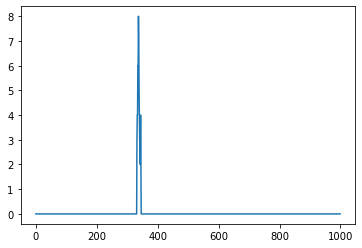

In [9]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1)
# randIndex = 4388191 #
# randIndex = 4880157 #需要初始
# randIndex = 5886548 #太多了
# randIndex = 5186074
# randIndex = 3793364
# randIndex = 3218203
# randIndex = 690724
# randIndex = 3552877
# randIndex = 1070346
# randIndex = 157776
# randIndex = 5673090
cancelledWF = denoisedTrainWF[randIndex]
wfArgmax = getPePerWF(cancelledWF, pointsPerTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"结果是{wfArgmax}")
plt.plot(denoisedTrainWF[randIndex])
plt.show()

下面检验三个feature对于真正的`pePerTrainWF`的关系，画出三个散点图：

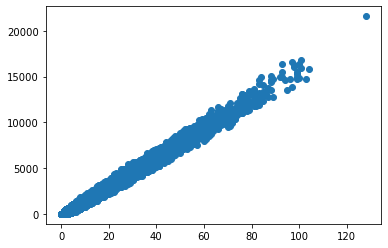

In [11]:
plt.scatter(pePerTrainWF, intTrainWF)
plt.show()

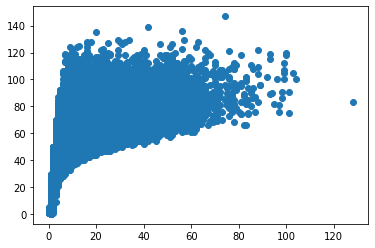

In [12]:
plt.scatter(pePerTrainWF, pointsPerTrainWF)
plt.show()

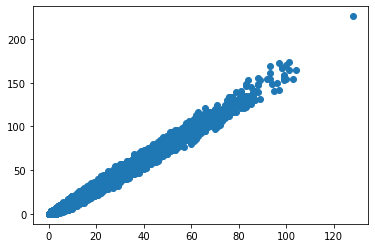

In [13]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.show()

__如果已经跑了waveform.py__: 运行以下代码，将下面需要用到的数据读取出来

In [60]:
intTrainWF = np.array([], dtype='<i4')
pointsPerTrainWF = np.array([], dtype='<i2')
pePerTrainWFCalc = np.array([], dtype='<i2')
meanPeTimePerTrainWF = np.array([], dtype='<f8')
pePerTrainWF = np.array([], dtype='<i2')

for i in tqdm(range(2, 7)):
    with h5py.File(f"./train/final_{i}_wf.h5", 'r') as ipt:
        intTrainWF = np.append(intTrainWF, ipt['Waveform']['intWF'][...])
        pointsPerTrainWF = np.append(pointsPerTrainWF, ipt['Waveform']['pointsPerWF'][...])
        pePerTrainWFCalc = np.append(pePerTrainWFCalc, ipt['Waveform']['pePerWFCalc'][...])
        meanPeTimePerTrainWF = np.append(meanPeTimePerTrainWF, ipt['Waveform']['meanPeTimePerWF'][...])

    trainPET, trainWF, trainPT = loadData(f"./data/final-{i}.h5", 'PT')
    numPET, peIndices = getNum(trainPET)
    numPEW, wfIndices = getNum(trainWF)
    splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
    for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
        channels, counts = np.unique(arr, return_counts=True)
        zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
        while zeroPeChannelCount:
            alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
            indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
            channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
            counts = np.insert(counts, indexToInsert, 0)
            zeroPeChannelCount -= 1
    
        pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)

  0%|          | 0/5 [00:00<?, ?it/s]

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform



 20%|██        | 1/5 [01:13<04:55, 73.77s/it]

Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform



 65%|██████▌   | 1300/2000 [00:17<00:18, 38.65it/s]


 91%|█████████▏| 1829/2000 [00:35<00:08, 20.03it/s]


 40%|████      | 2/5 [02:52<04:25, 88.52s/it]

Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform



 23%|██▎       | 452/2000 [00:19<01:08, 22.68it/s]


 45%|████▌     | 903/2000 [00:39<00:52, 20.89it/s]


 63%|██████▎   | 1264/2000 [00:59<00:50, 14.61it/s]


 78%|███████▊  | 1560/2000 [01:19<00:26, 16.71it/s]


 93%|█████████▎| 1856/2000 [01:39<00:08, 17.01it/s]


 60%|██████    | 3/5 [05:37<04:06, 123.48s/it]

Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), type "|V2008"> Waveform /Waveform



 15%|█▌        | 302/2000 [00:18<01:42, 16.56it/s]


 30%|███       | 604/2000 [00:37<01:33, 14.91it/s]


 45%|████▌     | 906/2000 [00:57<01:12, 15.10it/s]


 60%|██████    | 1204/2000 [01:17<00:56, 13.97it/s]


 75%|███████▌  | 1500/2000 [01:39<00:36, 13.76it/s]


 90%|████████▉ | 1796/2000 [02:01<00:14, 14.28it/s]


 80%|████████  | 4/5 [08:48<02:30, 150.11s/it]

Structure of data:
<HDF5 dataset "PETruth": shape (9262473,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6115519,), type "|V2008"> Waveform /Waveform



 15%|█▌        | 302/2000 [00:21<02:04, 13.61it/s]


 30%|███       | 604/2000 [00:46<02:01, 11.45it/s]


 45%|████▌     | 905/2000 [01:13<01:32, 11.84it/s]


 60%|██████    | 1202/2000 [01:39<01:13, 10.79it/s]


 74%|███████▍  | 1488/2000 [02:06<00:54,  9.35it/s]


 87%|████████▋ | 1739/2000 [02:31<00:25, 10.19it/s]


100%|██████████| 5/5 [12:34<00:00, 150.83s/it]


In [76]:
wfIndices = np.zeros(10001, dtype=int)
p = np.zeros(10000)
for i in range(2, 7):
    trainPET, trainWF, trainPT = loadData(f"./data/final-{i}.h5", 'PT')
    numPEW, wfFakeIndices = getNum(trainWF)
    wfIndices[(i-2)*2000:(i-1)*2000+1] = wfFakeIndices + wfIndices[(i-2)*2000]
    p[(i-2)*2000:(i-1)*2000] = trainPT['p']

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform
Structure of data:
<HDF5 dataset "PETruth": shape (9222643,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6021458,), type "|V2008"> Waveform /Waveform
Structure of data:
<HDF5 dataset "PETruth": shape (9009875,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (5987414,), type "|V2008"> Waveform /Waveform
Structure of data:
<HDF5 dataset "PETruth": shape (9147704,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6004696,), ty

用gbm，训练从以上三个feature到pePerTrainWF的模型：

In [62]:
trainDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[:-500000], pointsPerTrainWF[:-500000], pePerTrainWFCalc[:-500000]),
        axis=1
    ),
    label=pePerTrainWF[:-500000],
)
validationDataForPePerWF = lgb.Dataset(
    np.stack(
        (intTrainWF[-500000:], pointsPerTrainWF[-500000:], pePerTrainWFCalc[-500000:]),
        axis=1
    ),
    label=pePerTrainWF[-500000:],
    reference=trainDataForPePerWF,
)
trainDataForPePerWF.save_binary('./train/trainPePerWF.bin')
validationDataForPePerWF.save_binary('./train/validPePerWF.bin')

[LightGBM] [Info] Saving data to binary file ./train/trainPePerWF.bin
[LightGBM] [Info] Saving data to binary file ./train/validPePerWF.bin


In [63]:
trainDataForPePerWF = lgb.Dataset('./train/trainPePerWF.bin')
validationDataForPePerWF = lgb.Dataset('./train/validPePerWF.bin', reference=trainDataForPePerWF)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForPePerWF = lgb.train(
    params,
    trainDataForPePerWF,
    num_boost_round=3000,
    valid_sets=validationDataForPePerWF,
    early_stopping_rounds=300,
)
gbmForPePerWF.save_model('modelPePerWF.txt')

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.126287 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[1]	valid_0's rmse: 1.80924
Training until validation scores don't improve for 300 rounds
[2]	valid_0's rmse: 1.79145
[3]	valid_0's rmse: 1.77385
[4]	valid_0's rmse: 1.75642
[5]	valid_0's rmse: 1.73918
[6]	valid_0's rmse: 1.7221
[7]	valid_0's rmse: 1.70521
[8]	valid_0's rmse: 1.68849
[9]	valid_0's rmse: 1.67193
[10]	valid_0's rmse: 1.65555
[11]	valid_0's rmse: 1.63934
[12]	valid_0's rmse: 1.62329
[13]	valid_0's rmse: 1.60741
[14]	valid_0's rmse: 1.59169
[15]	valid_0's rmse: 1.57613
[16]	valid_0's rmse: 1.56073
[17]	valid_0's rmse: 1.54549
[18]	valid_0's rmse: 1.53041
[19]	valid_0's rmse: 1.51548
[20]	valid_0's rmse: 1.50071
[21]	valid_0's rmse: 1.48609
[22]	valid_0's rmse: 1.47162
[23]	valid_0's rmse: 1.4573
[24]	valid_0's rmse: 1.44312
[25]	valid_0's rmse: 1.4

[263]	valid_0's rmse: 0.292579
[264]	valid_0's rmse: 0.292052
[265]	valid_0's rmse: 0.291537
[266]	valid_0's rmse: 0.29103
[267]	valid_0's rmse: 0.290535
[268]	valid_0's rmse: 0.290049
[269]	valid_0's rmse: 0.289572
[270]	valid_0's rmse: 0.289103
[271]	valid_0's rmse: 0.288644
[272]	valid_0's rmse: 0.288193
[273]	valid_0's rmse: 0.287752
[274]	valid_0's rmse: 0.287319
[275]	valid_0's rmse: 0.286894
[276]	valid_0's rmse: 0.286478
[277]	valid_0's rmse: 0.286068
[278]	valid_0's rmse: 0.285666
[279]	valid_0's rmse: 0.285274
[280]	valid_0's rmse: 0.28489
[281]	valid_0's rmse: 0.284513
[282]	valid_0's rmse: 0.284142
[283]	valid_0's rmse: 0.283778
[284]	valid_0's rmse: 0.283421
[285]	valid_0's rmse: 0.283072
[286]	valid_0's rmse: 0.282729
[287]	valid_0's rmse: 0.282395
[288]	valid_0's rmse: 0.282067
[289]	valid_0's rmse: 0.281745
[290]	valid_0's rmse: 0.281428
[291]	valid_0's rmse: 0.281118
[292]	valid_0's rmse: 0.280814
[293]	valid_0's rmse: 0.280515
[294]	valid_0's rmse: 0.280225
[295]	vali

[528]	valid_0's rmse: 0.267066
[529]	valid_0's rmse: 0.267065
[530]	valid_0's rmse: 0.267067
[531]	valid_0's rmse: 0.267067
[532]	valid_0's rmse: 0.267067
[533]	valid_0's rmse: 0.267068
[534]	valid_0's rmse: 0.26707
[535]	valid_0's rmse: 0.267071
[536]	valid_0's rmse: 0.267073
[537]	valid_0's rmse: 0.267074
[538]	valid_0's rmse: 0.267075
[539]	valid_0's rmse: 0.267076
[540]	valid_0's rmse: 0.267078
[541]	valid_0's rmse: 0.267078
[542]	valid_0's rmse: 0.26708
[543]	valid_0's rmse: 0.267081
[544]	valid_0's rmse: 0.267081
[545]	valid_0's rmse: 0.267083
[546]	valid_0's rmse: 0.267084
[547]	valid_0's rmse: 0.267085
[548]	valid_0's rmse: 0.267087
[549]	valid_0's rmse: 0.267088
[550]	valid_0's rmse: 0.267089
[551]	valid_0's rmse: 0.267092
[552]	valid_0's rmse: 0.267093
[553]	valid_0's rmse: 0.267094
[554]	valid_0's rmse: 0.267095
[555]	valid_0's rmse: 0.267096
[556]	valid_0's rmse: 0.267098
[557]	valid_0's rmse: 0.267099
[558]	valid_0's rmse: 0.267099
[559]	valid_0's rmse: 0.267102
[560]	vali

[794]	valid_0's rmse: 0.267361
[795]	valid_0's rmse: 0.267362
[796]	valid_0's rmse: 0.267362
[797]	valid_0's rmse: 0.267363
[798]	valid_0's rmse: 0.267363
[799]	valid_0's rmse: 0.267364
[800]	valid_0's rmse: 0.267364
[801]	valid_0's rmse: 0.267365
[802]	valid_0's rmse: 0.267365
[803]	valid_0's rmse: 0.267366
[804]	valid_0's rmse: 0.267367
[805]	valid_0's rmse: 0.267368
[806]	valid_0's rmse: 0.267369
[807]	valid_0's rmse: 0.26737
[808]	valid_0's rmse: 0.26737
[809]	valid_0's rmse: 0.267371
[810]	valid_0's rmse: 0.267372
[811]	valid_0's rmse: 0.267372
Early stopping, best iteration is:
[511]	valid_0's rmse: 0.267062


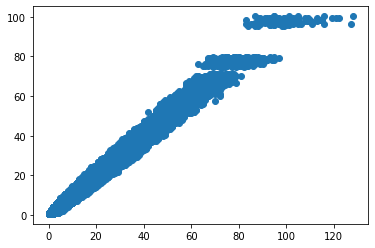

[210031 666103 169883]


In [68]:
gbmForPePerWF = lgb.Booster(model_file='./modelPePerWF.txt')
pePerTrainWFFinal = gbmForPePerWF.predict(
    np.stack(
        (intTrainWF, pointsPerTrainWF, pePerTrainWFCalc),
        axis=1
    )
)
plt.scatter(pePerTrainWF, pePerTrainWFFinal)
plt.show()
print(gbmForPePerWF.feature_importance())

In [71]:
splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1].astype(int))
peTotal = np.empty(10000)
peMean = np.empty(10000)
peStd = np.empty(10000)
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1].astype(int))
peTimeMean = np.empty(10000)
peTimeStd = np.empty(10000)
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)


100%|██████████| 10000/10000 [00:01<00:00, 5013.18it/s]


In [72]:
plt.scatter(peTimeMean, trainPT['p']/peTotal)
plt.show()

ValueError: operands could not be broadcast together with shapes (2000,) (10000,) 

In [77]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-1000], peMean[:-1000], peStd[:-1000], peTimeMean[:-1000], peTimeStd[:-1000]),
        axis=1
    ),
    label=p[:-1000]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-1000:], peMean[-1000:], peStd[-1000:], peTimeMean[-1000:], peTimeStd[-1000:]),
        axis=1
    ),
    label=p[-1000:],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=3000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('modelP.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 6.23331	valid_0's custom: 5.47129
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 6.17136	valid_0's custom: 5.36293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 6.11003	valid_0's custom: 5.25673
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 6.04929	valid_0's custom: 5.15259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 5.98921	valid_0's custom: 5.05061
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's rmse: 3.1655	valid_0's custom: 1.40774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's rmse: 3.13428	valid_0's custom: 1.38005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's rmse: 3.10334	valid_0's custom: 1.35289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's rmse: 3.07271	valid_0's custom: 1.32627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's rmse: 3.04239	valid_0's custom: 1.30017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's rmse: 3.01237	valid_0's custom: 1.27459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's rmse: 2.98268	valid_0's custom: 1.24953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's r

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's rmse: 1.4887	valid_0's custom: 0.309987
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	valid_0's rmse: 1.47449	valid_0's custom: 0.30407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[148]	valid_0's rmse: 1.46042	valid_0's custom: 0.298269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[149]	valid_0's rmse: 1.44649	valid_0's custom: 0.292583
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[150]	valid_0's rmse: 1.43271	valid_0's custom: 0.287013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 1.41907	valid_0's custom: 0.281546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 1.40556	valid_0's custom: 0.27619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's rmse: 0.738611	valid_0's custom: 0.0756943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's rmse: 0.732469	valid_0's custom: 0.0744318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's rmse: 0.726412	valid_0's custom: 0.0731975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[226]	valid_0's rmse: 0.720406	valid_0's custom: 0.0719833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[227]	valid_0's rmse: 0.714454	valid_0's custom: 0.0707909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	valid_0's rmse: 0.7086	valid_0's custom: 0.0696272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's rmse: 0.702824	valid_0's custom: 0.0684887
[LightGBM] [Warning] No further splits with positive gain, best 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[299]	valid_0's rmse: 0.433658	valid_0's custom: 0.0259543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	valid_0's rmse: 0.431378	valid_0's custom: 0.0256817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[301]	valid_0's rmse: 0.429127	valid_0's custom: 0.0254134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[302]	valid_0's rmse: 0.426892	valid_0's custom: 0.0251505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's rmse: 0.424718	valid_0's custom: 0.0248954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's rmse: 0.422561	valid_0's custom: 0.0246427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[305]	valid_0's rmse: 0.420437	valid_0's custom: 0.0243951
[LightGBM] [Warning] No further splits with positive gain, bes

[365]	valid_0's rmse: 0.33744	valid_0's custom: 0.0158283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[366]	valid_0's rmse: 0.336636	valid_0's custom: 0.0157554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[367]	valid_0's rmse: 0.335828	valid_0's custom: 0.0156825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[368]	valid_0's rmse: 0.335041	valid_0's custom: 0.015612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[369]	valid_0's rmse: 0.334234	valid_0's custom: 0.0155391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[370]	valid_0's rmse: 0.33347	valid_0's custom: 0.015471
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[371]	valid_0's rmse: 0.332728	valid_0's custom: 0.0154048
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's rmse: 0.331972	valid_0's custom: 0.0153376
[LightG

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[441]	valid_0's rmse: 0.302063	valid_0's custom: 0.0128915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[442]	valid_0's rmse: 0.301823	valid_0's custom: 0.0128746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[443]	valid_0's rmse: 0.301577	valid_0's custom: 0.0128586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[444]	valid_0's rmse: 0.301336	valid_0's custom: 0.0128418
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[445]	valid_0's rmse: 0.301109	valid_0's custom: 0.0128262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[446]	valid_0's rmse: 0.300866	valid_0's custom: 0.0128093
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[447]	valid_0's rmse: 0.300638	valid_0's custom: 0.0127911
[LightGBM] [Warning] No further splits with positive gain, bes

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[506]	valid_0's rmse: 0.291967	valid_0's custom: 0.012168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[507]	valid_0's rmse: 0.291881	valid_0's custom: 0.0121621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[508]	valid_0's rmse: 0.291788	valid_0's custom: 0.0121571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[509]	valid_0's rmse: 0.291697	valid_0's custom: 0.0121521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's rmse: 0.291596	valid_0's custom: 0.0121446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's rmse: 0.291522	valid_0's custom: 0.0121412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's rmse: 0.291473	valid_0's custom: 0.0121372
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[574]	valid_0's rmse: 0.288932	valid_0's custom: 0.0120071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[575]	valid_0's rmse: 0.288892	valid_0's custom: 0.0120045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[576]	valid_0's rmse: 0.288848	valid_0's custom: 0.0120023
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[577]	valid_0's rmse: 0.288808	valid_0's custom: 0.0120012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[578]	valid_0's rmse: 0.28877	valid_0's custom: 0.011999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[579]	valid_0's rmse: 0.288729	valid_0's custom: 0.0119972
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[580]	valid_0's rmse: 0.288692	valid_0's custom: 0.0119955
[LightGBM] [Warning] No further splits with positive gain, best 

[662]	valid_0's rmse: 0.288748	valid_0's custom: 0.0120794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's rmse: 0.288722	valid_0's custom: 0.0120809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's rmse: 0.288696	valid_0's custom: 0.0120819
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's rmse: 0.288668	valid_0's custom: 0.0120824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's rmse: 0.288642	valid_0's custom: 0.0120844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's rmse: 0.288617	valid_0's custom: 0.0120856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[668]	valid_0's rmse: 0.288572	valid_0's custom: 0.012085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's rmse: 0.288529	valid_0's custom: 0.0120853
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 0.287898	valid_0's custom: 0.0121235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 0.287933	valid_0's custom: 0.0121258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[738]	valid_0's rmse: 0.287887	valid_0's custom: 0.0121248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[739]	valid_0's rmse: 0.287882	valid_0's custom: 0.0121259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[740]	valid_0's rmse: 0.28791	valid_0's custom: 0.0121281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[741]	valid_0's rmse: 0.287943	valid_0's custom: 0.0121297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[742]	valid_0's rmse: 0.287897	valid_0's custom: 0.0121283
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 0.288719	valid_0's custom: 0.0122133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 0.288668	valid_0's custom: 0.0122108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's rmse: 0.288692	valid_0's custom: 0.0122124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's rmse: 0.288731	valid_0's custom: 0.0122155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's rmse: 0.288744	valid_0's custom: 0.0122173
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's rmse: 0.288751	valid_0's custom: 0.0122175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's rmse: 0.288753	valid_0's custom: 0.012217
[LightGBM] [Warning] No further splits with positive gain, best

In [31]:
splitPePerTrainWF = np.split(pePerTrainWF, wfIndices[1:-1])
peTotal = np.empty(2000)
peMean = np.empty(2000)
peStd = np.empty(2000)
for index, pePerTrainWFChunk in enumerate(tqdm(splitPePerTrainWF)):
    peTotal[index] = np.sum(pePerTrainWFChunk)
    peMean[index] = np.mean(pePerTrainWFChunk)
    peStd[index] = np.std(pePerTrainWFChunk)
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-100], peMean[:-100], peStd[:-100]),
        axis=1
    ),
    label=trainPT[:-100]['p']
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-100:], peMean[-100:], peStd[-100:]),
        axis=1
    ),
    label=trainPT[-100:]['p'],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 20,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=3000,
    valid_sets=validationDataForP,
    early_stopping_rounds=300
)
gbmForP.save_model('modelP2.txt')

100%|██████████| 2000/2000 [00:00<00:00, 11182.28it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000318 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3.10284
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 3.0726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 3.04264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 3.01301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2.98375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2.95468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2.92596
[LightGBM] [Warning] No further splits with positive 

[130]	valid_0's rmse: 0.902127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's rmse: 0.893824
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's rmse: 0.885448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's rmse: 0.877339
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's rmse: 0.86917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's rmse: 0.86121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's rmse: 0.853321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's rmse: 0.845481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's rmse: 0.837743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's rmse: 0.830116
[LightGBM] [Warni

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[263]	valid_0's rmse: 0.314594
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[264]	valid_0's rmse: 0.312725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[265]	valid_0's rmse: 0.310946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[266]	valid_0's rmse: 0.309169
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[267]	valid_0's rmse: 0.307387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[268]	valid_0's rmse: 0.30568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's rmse: 0.30394
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's rmse: 0.302229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's rmse: 0.300605
[LightGBM] [Warning] No further splits with posi

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[388]	valid_0's rmse: 0.203383
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[389]	valid_0's rmse: 0.203096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[390]	valid_0's rmse: 0.202844
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[391]	valid_0's rmse: 0.202543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[392]	valid_0's rmse: 0.202283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	valid_0's rmse: 0.20196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's rmse: 0.201697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	valid_0's rmse: 0.201379
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's rmse: 0.201143
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[510]	valid_0's rmse: 0.183908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[511]	valid_0's rmse: 0.18387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[512]	valid_0's rmse: 0.183803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[513]	valid_0's rmse: 0.183758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's rmse: 0.18369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 0.183671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 0.183612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 0.18358
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 0.183494
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[637]	valid_0's rmse: 0.177958
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[638]	valid_0's rmse: 0.177945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[639]	valid_0's rmse: 0.177899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[640]	valid_0's rmse: 0.17787
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[641]	valid_0's rmse: 0.177881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[642]	valid_0's rmse: 0.177809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[643]	valid_0's rmse: 0.177814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[644]	valid_0's rmse: 0.177784
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[645]	valid_0's rmse: 0.177781
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's rmse: 0.176452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's rmse: 0.176439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's rmse: 0.176462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's rmse: 0.176444
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[820]	valid_0's rmse: 0.176406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[821]	valid_0's rmse: 0.176428
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[822]	valid_0's rmse: 0.176416
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[823]	valid_0's rmse: 0.176437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[824]	valid_0's rmse: 0.17643
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[922]	valid_0's rmse: 0.176276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[923]	valid_0's rmse: 0.176266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 0.176268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 0.176271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 0.176259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 0.176264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's rmse: 0.176268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's rmse: 0.176255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's rmse: 0.176264
[LightGBM] [Warning] No further splits with po

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1030]	valid_0's rmse: 0.176858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1031]	valid_0's rmse: 0.176853
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1032]	valid_0's rmse: 0.176849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1033]	valid_0's rmse: 0.176874
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 0.176867
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's rmse: 0.176892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's rmse: 0.176892
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's rmse: 0.176916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's rmse: 0.176911
[LightGBM] [Warning] No further split

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1136]	valid_0's rmse: 0.177267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1137]	valid_0's rmse: 0.177279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1138]	valid_0's rmse: 0.177297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1139]	valid_0's rmse: 0.177293
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1140]	valid_0's rmse: 0.177294
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1141]	valid_0's rmse: 0.177297
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1142]	valid_0's rmse: 0.177278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1143]	valid_0's rmse: 0.17729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1144]	valid_0's rmse: 0.177298
[LightGBM] [Warning] No further splits

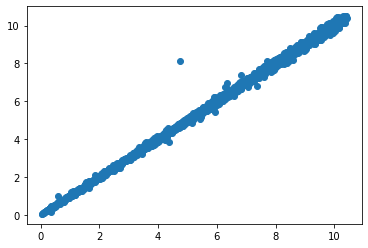

In [55]:
plt.scatter(
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    ),
    trainPT['p']
)

In [85]:
splitPePerTrainWFFinal = np.split(pePerTrainWFFinal, wfIndices[1:-1])
featuresForXYZ = np.empty((2000, 4))
channelsMostPe = np.empty((2000, 3), dtype=int)
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    channelsMostPe[index] = np.argsort(pePerTrainWFFinalChunk)[-3:]
    featuresForXYZ[index] = [
        np.cos(geo[channelsMostPe[index, 0]]['theta']/180*np.pi), 
        np.sin(geo[channelsMostPe[index, 0]]['phi']/180*np.pi), 
        pePerTrainWFFinal[channelsMostPe[index, 0]],
        meanPeTimePerTrainWF[channelsMostPe[index, 0]]*300,
        #geo[channelsMostPe[index, 1]]['theta'], 
        #geo[channelsMostPe[index, 1]]['phi'], 
        #pePerTrainWFFinal[channelsMostPe[index, 1]],
        #meanPeTimePerTrainWF[channelsMostPe[index, 1]],
        #geo[channelsMostPe[index, 2]]['theta'], 
        #geo[channelsMostPe[index, 2]]['phi'], 
        #pePerTrainWFFinal[channelsMostPe[index, 2]],
        #meanPeTimePerTrainWF[channelsMostPe[index, 2]]
    ]
    

trainDataForX = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['x'][:-200]
)
validationDataForX = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['x'][-200:],
    reference=trainDataForX
)
trainDataForX.save_binary('./train/trainX.bin')
validationDataForX.save_binary('./train/validX.bin')

trainDataForY = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['y'][:-200]
)
validationDataForY = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['y'][-200:],
    reference=trainDataForY
)
trainDataForY.save_binary('./train/trainY.bin')
validationDataForY.save_binary('./train/validY.bin')

trainDataForZ = lgb.Dataset(
    featuresForXYZ[:-200],
    label=trainPT['z'][:-200]
)
validationDataForZ = lgb.Dataset(
    featuresForXYZ[-200:],
    label=trainPT['z'][-200:],
    reference=trainDataForZ
)
trainDataForZ.save_binary('./train/trainZ.bin')
validationDataForZ.save_binary('./train/validZ.bin')

100%|██████████| 2000/2000 [00:00<00:00, 14024.47it/s]

[LightGBM] [Info] Saving data to binary file ./train/trainX.bin
[LightGBM] [Info] Saving data to binary file ./train/validX.bin
[LightGBM] [Warning] File ./train/trainY.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validY.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/trainZ.bin exists, cannot save binary to it
[LightGBM] [Warning] File ./train/validZ.bin exists, cannot save binary to it


In [86]:
trainDataForX = lgb.Dataset('./train/trainX.bin')
validationDataForX = lgb.Dataset('./train/validX.bin', reference=trainDataForX)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**15,
    'learning_rate': 0.001,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 500,
}
gbmForX = lgb.train(
    params,
    trainDataForX,
    num_boost_round=3000,
    valid_sets=validationDataForX,
    early_stopping_rounds=300
)
gbmForX.save_model('modelX.txt')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 7714.61
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 7714.83
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 7715.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 7715.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 7715.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 7715.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 7715.94
[LightGBM] [Warning] No further splits with positive 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's rmse: 7731.27
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[85]	valid_0's rmse: 7731.5
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's rmse: 7731.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's rmse: 7731.86
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's rmse: 7732.08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's rmse: 7732.26
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's rmse: 7732.47
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's rmse: 7732.7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's rmse: 7732.83
[LightGBM] [Warning] No further splits with positive gain, best ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 7748.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 7748.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's rmse: 7748.66
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's rmse: 7748.82
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's rmse: 7748.98
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's rmse: 7749.02
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's rmse: 7749.16
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's rmse: 7749.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's rmse: 7749.47
[LightGBM] [Warning] No further splits with positive ga

[268]	valid_0's rmse: 7761.51
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[269]	valid_0's rmse: 7761.48
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[270]	valid_0's rmse: 7761.76
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[271]	valid_0's rmse: 7761.79
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[272]	valid_0's rmse: 7762.08
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[273]	valid_0's rmse: 7762.11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[274]	valid_0's rmse: 7762.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[275]	valid_0's rmse: 7762.32
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[276]	valid_0's rmse: 7762.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[277]	valid_0's rmse: 7762.33
[LightGBM] [Warning] No f

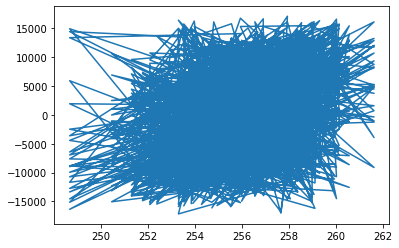

In [87]:
plt.plot(gbmForX.predict(featuresForXYZ), trainPT['x'])
plt.show()

In [708]:
from hyperopt import fmin, tpe, hp
best = fmin(
    fn=getPETime,
    space=[
        hp.uniform('point_judge', 0, 10),
        hp.uniform('int_judge', 60, 200),
        hp.uniform('cancel_max', 10, 25),
        hp.uniform('noise_thre', 0, 10),
        hp.uniform('point_minus', 10, 30),
        hp.uniform('int_minus', 100, 200),
    ],
    algo=tpe.suggest,
    max_evals=100)
print(best)

  3%|▎         | 3/100 [00:03<01:54,  1.18s/trial, best loss: -8661.0]


KeyboardInterrupt: 

In [26]:
saveData(X1, trainPT, './train/train1.h5')

In [27]:
X1, Y1 = loadData('./data/train1.h5', 'pro')

OSError: Unable to open file (unable to open file: name = './data/train1.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
train_data1 = lgb.Dataset(X1[:-100], label=Y1[:-100])
validation_data1 = lgb.Dataset(np.array(X1[-100:]), np.array(Y1[-100:]), reference=train_data1)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'rmse'},
    'num_leaves': 2**11,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 11,
}
gbm1 = lgb.train(params,
                 train_data1,
                 num_boost_round=3000,
                 valid_sets=validation_data1,
                 early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 14727.9
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 14582.1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 14437.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 14295.3
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 14153.9
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 14014.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 13875.8
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's rmse: 2950.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's rmse: 2924.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's rmse: 2899.22
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's rmse: 2873.91
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's rmse: 2848.92
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's rmse: 2824.21
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's rmse: 2799.74
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's rmse: 2775.4
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's rmse: 2751.25
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[253]	valid_0's rmse: 1549.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[254]	valid_0's rmse: 1540.36
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[255]	valid_0's rmse: 1531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[256]	valid_0's rmse: 1521.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[257]	valid_0's rmse: 1512.88
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[258]	valid_0's rmse: 1503.8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[259]	valid_0's rmse: 1495.06
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[260]	valid_0's rmse: 1486.12
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[261]	valid_0's rmse: 1477.29
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's rmse: 1060.57
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's rmse: 1057.77
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's rmse: 1055.07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[344]	valid_0's rmse: 1052.28
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's rmse: 1049.68
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's rmse: 1047.09
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's rmse: 1044.38
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's rmse: 1041.94
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's rmse: 1039.36
[LightGBM] [Warning] No further splits with positive ga

[420]	valid_0's rmse: 940.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[421]	valid_0's rmse: 939.961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[422]	valid_0's rmse: 939.336
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[423]	valid_0's rmse: 938.413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[424]	valid_0's rmse: 937.611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[425]	valid_0's rmse: 937.007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[426]	valid_0's rmse: 936.053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[427]	valid_0's rmse: 935.584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[428]	valid_0's rmse: 934.72
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[429]	valid_0's rmse: 934.266
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[514]	valid_0's rmse: 905.912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[515]	valid_0's rmse: 905.828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[516]	valid_0's rmse: 905.415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[517]	valid_0's rmse: 905.399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[518]	valid_0's rmse: 905.308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[519]	valid_0's rmse: 904.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[520]	valid_0's rmse: 904.681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[521]	valid_0's rmse: 904.595
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[522]	valid_0's rmse: 904.406
[LightGBM] [Warning] No further splits with positive ga

[601]	valid_0's rmse: 891.506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 891.62
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 891.737
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 891.852
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 891.996
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 892.116
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 892.251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 892.432
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[609]	valid_0's rmse: 892.446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[610]	valid_0's rmse: 892.458
[LightGBM] [Warning] No fu

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[724]	valid_0's rmse: 885.606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[725]	valid_0's rmse: 885.645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[726]	valid_0's rmse: 885.566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[727]	valid_0's rmse: 885.574
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[728]	valid_0's rmse: 885.397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 885.396
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 885.319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 885.242
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 885.167
[LightGBM] [Warning] No further splits with positive ga

[877]	valid_0's rmse: 884.897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[878]	valid_0's rmse: 884.885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[879]	valid_0's rmse: 885.026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[880]	valid_0's rmse: 884.908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[881]	valid_0's rmse: 884.896
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[882]	valid_0's rmse: 884.865
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[883]	valid_0's rmse: 884.719
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[884]	valid_0's rmse: 884.739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[885]	valid_0's rmse: 884.821
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[886]	valid_0's rmse: 884.903
[LightGBM] [Warning] No f

[1033]	valid_0's rmse: 885.741
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1034]	valid_0's rmse: 885.837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1035]	valid_0's rmse: 885.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1036]	valid_0's rmse: 885.724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1037]	valid_0's rmse: 885.729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1038]	valid_0's rmse: 885.827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1039]	valid_0's rmse: 885.708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1040]	valid_0's rmse: 885.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1041]	valid_0's rmse: 885.646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1042]	valid_0's rmse: 885.651
[LightGBM] [Warn

In [29]:
X2 = np.hstack((X1, gbm1.predict(X1).reshape(-1,1)))
Y2 = numPET

In [30]:
train_data2 = lgb.Dataset(X2[:-100], label=Y2[:-100])
validation_data2 = lgb.Dataset(np.array(X2[-100:]), np.array(Y2[-100:]), reference=train_data2)
gbm2 = lgb.train(params,
                train_data2,
                num_boost_round=3000,
                valid_sets=validation_data2,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 2322.35
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 2299.43
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 2276.69
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 2254.2
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2231.97
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2209.85
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2188
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[151]	valid_0's rmse: 530.883
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 525.768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 520.712
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 515.711
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 510.743
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 505.843
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 500.981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 496.197
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 491.407
[LightGBM] [Warning] No further splits with positive ga

[237]	valid_0's rmse: 235.87
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 233.75
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 231.678
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 229.605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 227.572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 225.552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 223.564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 221.593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's rmse: 219.653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's rmse: 217.687
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 118.188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 117.408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 116.643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 115.879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 115.132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 114.407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[329]	valid_0's rmse: 113.666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's rmse: 112.948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's rmse: 112.221
[LightGBM] [Warning] No further splits with positive ga

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[481]	valid_0's rmse: 66.9265
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[482]	valid_0's rmse: 66.8608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[483]	valid_0's rmse: 66.7728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[484]	valid_0's rmse: 66.668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[485]	valid_0's rmse: 66.6106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[486]	valid_0's rmse: 66.5053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[487]	valid_0's rmse: 66.4326
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's rmse: 66.3651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[489]	valid_0's rmse: 66.2752
[LightGBM] [Warning] No further splits with positive gai

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[563]	valid_0's rmse: 62.6469
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[564]	valid_0's rmse: 62.6133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[565]	valid_0's rmse: 62.5848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[566]	valid_0's rmse: 62.5531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[567]	valid_0's rmse: 62.5283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[568]	valid_0's rmse: 62.4992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[569]	valid_0's rmse: 62.4778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[570]	valid_0's rmse: 62.4533
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[571]	valid_0's rmse: 62.4282
[LightGBM] [Warning] No further splits with positive ga

[652]	valid_0's rmse: 60.6443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[653]	valid_0's rmse: 60.6433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[654]	valid_0's rmse: 60.6287
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[655]	valid_0's rmse: 60.616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[656]	valid_0's rmse: 60.5887
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[657]	valid_0's rmse: 60.5684
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[658]	valid_0's rmse: 60.5537
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[659]	valid_0's rmse: 60.526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[660]	valid_0's rmse: 60.5099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[661]	valid_0's rmse: 60.4979
[LightGBM] [Warning] No fur

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[765]	valid_0's rmse: 59.5018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[766]	valid_0's rmse: 59.4968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[767]	valid_0's rmse: 59.513
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[768]	valid_0's rmse: 59.5074
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[769]	valid_0's rmse: 59.5223
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[770]	valid_0's rmse: 59.514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[771]	valid_0's rmse: 59.5264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[772]	valid_0's rmse: 59.5408
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[773]	valid_0's rmse: 59.5356
[LightGBM] [Warning] No further splits with positive gain

[923]	valid_0's rmse: 59.333
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[924]	valid_0's rmse: 59.3332
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[925]	valid_0's rmse: 59.3413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[926]	valid_0's rmse: 59.3415
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[927]	valid_0's rmse: 59.3498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[928]	valid_0's rmse: 59.3472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[929]	valid_0's rmse: 59.3506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[930]	valid_0's rmse: 59.3539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[931]	valid_0's rmse: 59.3641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[932]	valid_0's rmse: 59.3681
[LightGBM] [Warning] No fu

[1121]	valid_0's rmse: 59.1897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1122]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1123]	valid_0's rmse: 59.194
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1124]	valid_0's rmse: 59.1877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1125]	valid_0's rmse: 59.1854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1126]	valid_0's rmse: 59.1899
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1127]	valid_0's rmse: 59.1857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1128]	valid_0's rmse: 59.1837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1129]	valid_0's rmse: 59.1891
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1130]	valid_0's rmse: 59.1869
[LightGBM] [Warn

[1335]	valid_0's rmse: 59.1487
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1336]	valid_0's rmse: 59.1514
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1337]	valid_0's rmse: 59.1529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1338]	valid_0's rmse: 59.1497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1339]	valid_0's rmse: 59.1518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1340]	valid_0's rmse: 59.1534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1341]	valid_0's rmse: 59.1528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1342]	valid_0's rmse: 59.1549
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1343]	valid_0's rmse: 59.1542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1344]	valid_0's rmse: 59.1544
[LightGBM] [War

[1543]	valid_0's rmse: 59.3255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1544]	valid_0's rmse: 59.3276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1545]	valid_0's rmse: 59.3319
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1546]	valid_0's rmse: 59.3285
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1547]	valid_0's rmse: 59.3318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1548]	valid_0's rmse: 59.3402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1549]	valid_0's rmse: 59.3411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1550]	valid_0's rmse: 59.34
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1551]	valid_0's rmse: 59.341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1552]	valid_0's rmse: 59.338
[LightGBM] [Warning

In [31]:
X = np.hstack((X2, gbm2.predict(X2).reshape(-1,1)))
# X = X2
Y = trainPT['p']/1-np.exp(-trainPT['vis_photons'])


In [32]:
train_data = lgb.Dataset(np.array(X[:-100]), label=np.array(Y[:-100]))
validation_data = lgb.Dataset(np.array(X[-100:]), np.array(Y[-100:]), reference=train_data)
gbm = lgb.train(params,
                train_data,
                num_boost_round=3000,
                valid_sets=validation_data,
                early_stopping_rounds=300)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's rmse: 3.10241
Training until validation scores don't improve for 300 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's rmse: 3.07174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's rmse: 3.04135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's rmse: 3.01128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's rmse: 2.98151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's rmse: 2.95203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's rmse: 2.92286
[LightGBM] [Warning] No further splits with positive

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[152]	valid_0's rmse: 0.722489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's rmse: 0.71599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's rmse: 0.709544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's rmse: 0.703146
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's rmse: 0.696847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's rmse: 0.690685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's rmse: 0.684491
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's rmse: 0.678393
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's rmse: 0.672338
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[236]	valid_0's rmse: 0.364633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[237]	valid_0's rmse: 0.362171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[238]	valid_0's rmse: 0.359695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[239]	valid_0's rmse: 0.35726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[240]	valid_0's rmse: 0.354902
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[241]	valid_0's rmse: 0.352543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's rmse: 0.350229
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's rmse: 0.347935
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's rmse: 0.345669
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[320]	valid_0's rmse: 0.23855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[321]	valid_0's rmse: 0.237746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's rmse: 0.237005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[323]	valid_0's rmse: 0.236308
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[324]	valid_0's rmse: 0.23554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[325]	valid_0's rmse: 0.234778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's rmse: 0.234036
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's rmse: 0.233321
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's rmse: 0.23257
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[406]	valid_0's rmse: 0.202573
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[407]	valid_0's rmse: 0.202356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[408]	valid_0's rmse: 0.202127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[409]	valid_0's rmse: 0.202
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[410]	valid_0's rmse: 0.201774
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[411]	valid_0's rmse: 0.201541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[412]	valid_0's rmse: 0.201402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[413]	valid_0's rmse: 0.201237
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[414]	valid_0's rmse: 0.201035
[LightGBM] [Warning] No further splits with posit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[496]	valid_0's rmse: 0.194124
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's rmse: 0.194046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's rmse: 0.194007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's rmse: 0.193946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's rmse: 0.193846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's rmse: 0.193809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	valid_0's rmse: 0.19377
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[503]	valid_0's rmse: 0.193691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[504]	valid_0's rmse: 0.193641
[LightGBM] [Warning] No further splits with pos

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's rmse: 0.191811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's rmse: 0.191773
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's rmse: 0.191786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[603]	valid_0's rmse: 0.191778
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[604]	valid_0's rmse: 0.191785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[605]	valid_0's rmse: 0.191798
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[606]	valid_0's rmse: 0.191799
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[607]	valid_0's rmse: 0.191802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[608]	valid_0's rmse: 0.191766
[LightGBM] [Warning] No further splits with po

[728]	valid_0's rmse: 0.191309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[729]	valid_0's rmse: 0.191271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[730]	valid_0's rmse: 0.191276
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[731]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[732]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[733]	valid_0's rmse: 0.191239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[734]	valid_0's rmse: 0.191219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[735]	valid_0's rmse: 0.191214
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[736]	valid_0's rmse: 0.191198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[737]	valid_0's rmse: 0.191185
[LightGBM] [War

[894]	valid_0's rmse: 0.1911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[895]	valid_0's rmse: 0.191091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[896]	valid_0's rmse: 0.19107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[897]	valid_0's rmse: 0.191055
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[898]	valid_0's rmse: 0.19104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[899]	valid_0's rmse: 0.191028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[900]	valid_0's rmse: 0.191008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[901]	valid_0's rmse: 0.191013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[902]	valid_0's rmse: 0.190995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[903]	valid_0's rmse: 0.190984
[LightGBM] [Warning

[1076]	valid_0's rmse: 0.191243
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1077]	valid_0's rmse: 0.191247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1078]	valid_0's rmse: 0.191259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1079]	valid_0's rmse: 0.191267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1080]	valid_0's rmse: 0.19125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1081]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1082]	valid_0's rmse: 0.191278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1083]	valid_0's rmse: 0.191269
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1084]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1085]	valid_0's rmse: 0.191266
[LightG

[1255]	valid_0's rmse: 0.191225
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1256]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1257]	valid_0's rmse: 0.191266
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1258]	valid_0's rmse: 0.19127
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1259]	valid_0's rmse: 0.191282
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1260]	valid_0's rmse: 0.191281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1261]	valid_0's rmse: 0.191283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1262]	valid_0's rmse: 0.191263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1263]	valid_0's rmse: 0.191255
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1264]	valid_0's rmse: 0.191262
[Light

In [196]:
Xtest = np.hstack((numPEWtest.reshape(-1, 1), intWFtest.reshape(-1, 1)))
Xt1 = np.hstack((Xtest, gbm1.predict(Xtest).reshape(-1,1)))
Xt = np.hstack((Xt1, gbm2.predict(Xt1).reshape(-1,1)))
# Xt = Xt1

In [195]:
from pynverse import inversefunc
trans = lambda x: x/1-np.exp(-x)
invtrans = inversefunc(trans)

In [197]:
ans_gbm = invtrans(gbm.predict(Xt))
expname = 'dGBM'
saveans(ans_gbm, './ans/'+expname+'.h5')

In [198]:
trainPET

array([[ 0.00000000e+00,  4.00000000e+00,  6.00022656e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  8.00000000e+00,  6.04903013e+02,
         1.00000000e+00],
       [ 0.00000000e+00,  1.10000000e+01,  5.76875682e+02,
         1.00000000e+00],
       ...,
       [ 1.99900000e+03,  1.75810000e+04,  6.01051849e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76070000e+04,  5.86866675e+02,
         1.00000000e+00],
       [ 1.99900000e+03,  1.76090000e+04,  6.40730998e+01,
        -1.00000000e+00]])

In [135]:
gbm1.feature_importance()

array([22543, 16897], dtype=int32)

In [10]:
trainPT[:, -1]

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])

In [33]:
# plt.scatter(trainPT[:, -1], numPEW)
# plt.scatter(trainPT[:, -1], numPET)
# plt.scatter(trainPT[:, -1], numPET1)
# plt.scatter(trainPT[:, -1], intWF/trainPT[:, -1])
# plt.scatter(trainPT[:, -2], trainPT[:,-2]/intWF)
# plt.scatter(gbm.predict(X), gbm.predict(X)/intWF)
# plt.scatter(np.log(trainPT[:, -2]+1), trainPT[:,-2]/numPEW)
# plt.scatter(np.log(gbm.predict(X)+1), gbm.predict(X)/numPEW)
plt.scatter(trainPT[:, -2]/np.log(trainPT[:, -2]+1), numPEW)
plt.scatter(gbm.predict(X), numPEW)
#plt.scatter(trainPT[:10, -1], trainPT[:10, -2]*1000)
# plt.scatter(gbm1.predict(X1), intWF/100)
#plt.scatter(trainPT[:10, -1], gbm.predict(X)[:10]*1000)
#plt.scatter(numPEW, numPET)
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

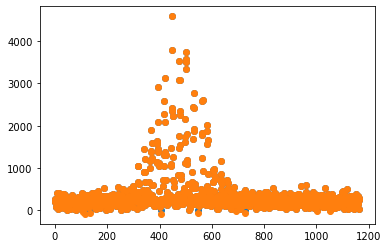

In [142]:
arr = invTrainWF[3085221:3086386]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.scatter(range(3086386-3085221),  (np.abs(intWF0)+intWF0)/2)
plt.scatter(range(3086386-3085221),  intWF0)
plt.show()

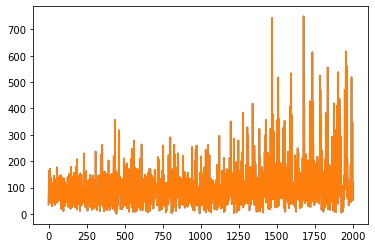

In [34]:
arr = invTrainWF[:2000]
head = np.mean(arr[:, :100], axis=1)
tail = np.mean(arr[:, -100:], axis=1)
base = np.minimum(head, tail)
intWF0 = np.sum(arr, axis=1)-base*1000
plt.plot(range(2000),  (np.abs(intWF0)+intWF0)/2)
plt.plot(range(2000),  intWF0)
plt.show()

In [135]:
np.argmin(intWF0)

2414

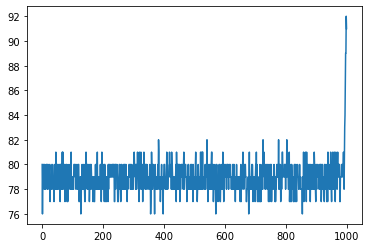

In [136]:
plt.plot(invTrainWF[2414])

In [85]:
j_tru[1007], j_tru[1008]

(3085221, 3086386)

In [17]:
X1

array([18971., 23288., 41752., ..., 10660., 12040., 11545.])